<a href="https://colab.research.google.com/github/matsunagalab/ColabBTR/blob/main/ColabBTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ColabBTR: Blind tip reconstruction on Google Colab

Easy to use notebook for using end-to-end differentiable blind tip reconstruction and removing the tip convoution artifacts from you AFM data.

*   This notebook can read and write several file formats of AFM data
*   Perform end-to-end differentiable blind tip reconsruction to reconstruct tip shape only from AFM data
*   Perform erosion (deconvoulution) with the reconstructed tip to remove tip convolution artifacts


[Y. Matsunaga, S. Fuchigami, T. Ogane, S. Takada. End-to-end differentiable blind tip reconstruction for noisy atomic force microscopy images.
*Scientific Reports*, 2023](https://www.nature.com/articles/s41598-022-27057-2)

In [14]:
#@title Install dependencies
%%time
import os

print("installing colabbtr...")
os.system("pip install -q --no-warn-conflicts git+https://github.com/matsunagalab/ColabBTR")

print("installing libasd...")
os.system("pip install -q --no-warn-conflicts libasd")

print("upgrading gdown...")
os.system("pip install -q --upgrade --no-warn-conflicts gdown")

print("installing spmpy...")
os.system("pip install -q --no-warn-conflicts git+https://github.com/kogens/spmpy")

print("installing gwyfile...")
os.system("pip install -q --no-warn-conflicts gwyfile")


installing colabbtr...
installing libasd...
upgrading gdown...
installing spmpy...
installing gwyfile...
CPU times: user 136 ms, sys: 17.4 ms, total: 153 ms
Wall time: 28.2 s


0

In [15]:
#@title Upload AFM data (asd, gwy, spm, npy, npz, csv files are supported)
from google.colab import files
import os
import re
import hashlib
import random

resolution_x = 1
resolution_y = 1

jobname = 'test'
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)

custom_path = os.path.join(jobname,f"afm_data")
os.makedirs(custom_path, exist_ok=True)
uploaded = files.upload()
for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_path,fn))

print("jobname",jobname)
print("custom_path",custom_path)

Saving images.npy to images.npy
jobname test
custom_path test/afm_data


In [18]:
#@title Load the uploaded data

import libasd
import numpy as np
import matplotlib.pyplot as plt
import gwyfile

channel_name_for_gwyfile = "topography"#@param {type:"string"}

file_path = []
for filename in os.listdir(custom_path):
    file_path.append(os.path.join(custom_path, filename))

if file_path[0].endswith('.asd'):
    process_asd(file_path)
    data = libasd.read_asd(file_path[0])
    print("version    = {}"     .format(data.header.file_version))
    print("image size = {}x{}"  .format(data.header.x_pixel, data.header.y_pixel))
    print("there are {} frames.".format(len(data.frames)))
    images = []
    for frame in data.frames:
        images.append(frame.image())
    images = np.array(images)

elif file_path[0].endswith('.gwy'):
    obj = gwyfile.load(file_path[0])
    channels = gwyfile.util.get_datafields(obj)
    channel = channels['topography']
    data = channel.data
    images = np.zeros((1, data.shape[0], data.shape[1]))
    images[0, :, :] = data

elif file_path[0].endswith('.npy'):
    images = np.load(file_path[0])

elif file_path[0].endswith('.npz'):
    images = np.load(file_path[0])

else:
    print("unsupported file type")

# create tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images_tensor = torch.tensor(images, dtype=torch.float32, device=device)

# display information
print("pixel height: ",images.shape[1])
print("pixel width: ",images.shape[2])
nframe = images.shape[0]
print("# of frames: ", nframe)

pixel height:  30
pixel width:  30
# of frames:  576


IntSlider(value=0, description='Frame:', layout=Layout(width='80%'), max=575)

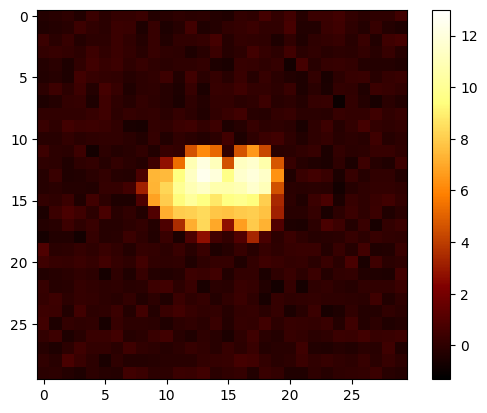

In [20]:
#@title Visualize the data

import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

images_or_movie = 'images' #@param ["images", "movie"] {allow-input: true}
first_frame = 0#@param {type:"raw"}
last_frame = nframe#@param {type:"raw"}
frame_per_second = 5#@param {type:"raw"}
vmin = images.min()#@param {type:"raw"}
vmax = images.max()#@param {type:"raw"}

if images_or_movie == 'images':
    # 初期のプロットを作成
    fig, ax = plt.subplots()
    image = ax.imshow(images[first_frame, :, :],
                        vmin=vmin, vmax=vmax, interpolation='none', origin='upper',
                        cmap="afmhot", aspect="equal")

    # show colorbar
    fig.colorbar(image, ax=ax)

    # スライダーの作成
    #slider = widgets.IntSlider(value=0, min=0, max=nframe, step=1, description='Slider:')
    # スライダーの作成（幅を調整）
    slider = widgets.IntSlider(value=0, min=first_frame, max=last_frame-1, step=1, description='Frame:',
                           layout=widgets.Layout(width='80%'))

    # イベントハンドラーの定義
    def on_value_change(change):
        # 画像データを更新
        new_data = images[change['new'], :, :]
        image.set_data(new_data)

        # プロットをクリアして再描画
        clear_output(wait=True)
        display(slider)
        display(fig)

    # スライダーにイベントハンドラーを関連付ける
    slider.observe(on_value_change, names='value')
    # スライダーとプロットを表示
    display(slider)
elif images_or_movie == 'movie':
    images_sub = images[first_frame:last_frame, :, :]
    fig, ax = plt.subplots()
    im = ax.imshow(images_sub[0, :, :],
                    vmin=vmin, vmax=vmax, interpolation='none', origin='upper',
                    cmap="afmhot", aspect="equal")
    # show colorbar
    fig.colorbar(image, ax=ax)
    def animate(i):
        im.set_data(images_sub[i, :, :])
        return [im]
    # アニメーションの作成
    anim = FuncAnimation(fig, animate, frames=len(images_sub), interval=200, blit=True)
    # HTML形式でアニメーションを表示
    HTML(anim.to_html5_video())


  0%|          | 0/100 [00:00<?, ?it/s]

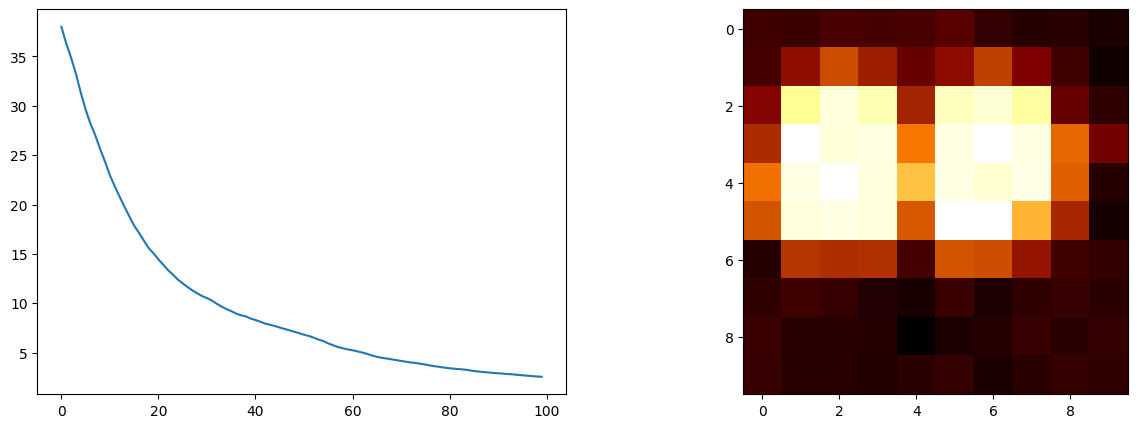

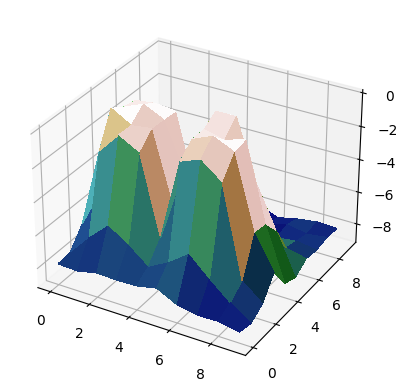

CPU times: user 1min 5s, sys: 267 ms, total: 1min 5s
Wall time: 1min 8s


In [23]:
#@title Run the end-to-end differentiable BTR and reconstruct tip shape from AFM images
%%time
from colabbtr.morphology import differentiable_btr

first_frame = 0#@param {type:"raw"}
last_frame = 10#@param {type:"raw"}
pixel_height = 10#@param {type:"raw"}
pixel_width = 10#@param {type:"raw"}
epoch = 100#@param {type:"raw"}
learning_rate = 0.1#@param {type:"raw"}
weight_decay = 0.0#@param {type:"raw"}

tip_tensor, loss = differentiable_btr(images_tensor[first_frame:last_frame, :, :],
                             (pixel_height, pixel_width),
                             nepoch=epoch, lr=learning_rate, weight_decay=weight_decay,
                             device=device)

tip = tip_tensor.to('cpu').numpy()

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LightSource
from matplotlib import cm

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(loss)

plt.subplot(1, 2, 2)
plt.imshow(tip, cmap="afmhot", aspect="equal")
plt.show()
#plt.imshow(idilation(surface_tensor, tip_tensor).cpu().detach().numpy(), cmap='afmhot')

nrows, ncols = tip.shape
# xとyの範囲を生成
x = np.arange(ncols)
y = np.arange(nrows)
x, y = np.meshgrid(x, y)
# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(tip, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, tip, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)
plt.show()


IntSlider(value=0, description='Frame:', layout=Layout(width='80%'), max=575)

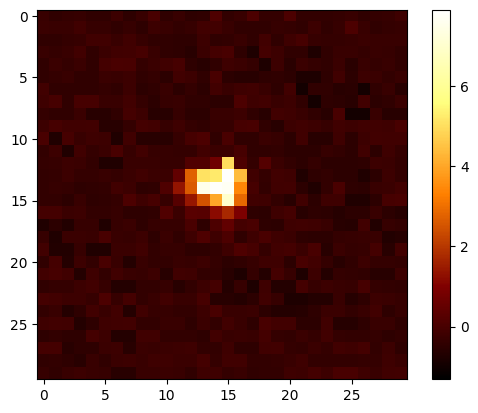

In [29]:
#@title Run erosion (deconvolution) with the reconstructed tip

import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from colabbtr.morphology import ierosion

images_eroded_tensor = torch.zeros_like(images_tensor, device=device)
for iframe in range(nframe):
    images_eroded_tensor[iframe, :, :] = ierosion(images_tensor[iframe, :, :], tip_tensor)

images_eroded = images_eroded_tensor.to('cpu').numpy()

images_or_movie = 'images' #@param ["images", "movie"] {allow-input: true}
first_frame = 0#@param {type:"raw"}
last_frame = nframe#@param {type:"raw"}
frame_per_second = 5#@param {type:"raw"}
vmin = images_eroded.min()#@param {type:"raw"}
vmax = images_eroded.max()#@param {type:"raw"}

if images_or_movie == 'images':
    # 初期のプロットを作成
    fig, ax = plt.subplots()
    image = ax.imshow(images_eroded[first_frame, :, :],
                        vmin=vmin, vmax=vmax, interpolation='none', origin='upper',
                        cmap="afmhot", aspect="equal")

    # show colorbar
    fig.colorbar(image, ax=ax)

    # スライダーの作成
    #slider = widgets.IntSlider(value=0, min=0, max=nframe, step=1, description='Slider:')
    # スライダーの作成（幅を調整）
    slider = widgets.IntSlider(value=0, min=first_frame, max=last_frame-1, step=1, description='Frame:',
                           layout=widgets.Layout(width='80%'))

    # イベントハンドラーの定義
    def on_value_change(change):
        # 画像データを更新
        new_data = images_eroded[change['new'], :, :]
        image.set_data(new_data)

        # プロットをクリアして再描画
        clear_output(wait=True)
        display(slider)
        display(fig)

    # スライダーにイベントハンドラーを関連付ける
    slider.observe(on_value_change, names='value')
    # スライダーとプロットを表示
    display(slider)
elif images_or_movie == 'movie':
    images_sub = images_eroded[first_frame:last_frame, :, :]
    fig, ax = plt.subplots()
    im = ax.imshow(images_sub[0, :, :],
                    vmin=vmin, vmax=vmax, interpolation='none', origin='upper',
                    cmap="afmhot", aspect="equal")
    # show colorbar
    fig.colorbar(image, ax=ax)
    def animate(i):
        im.set_data(images_sub[i, :, :])
        return [im]
    # アニメーションの作成
    anim = FuncAnimation(fig, animate, frames=len(images_sub), interval=200, blit=True)
    # HTML形式でアニメーションを表示
    HTML(anim.to_html5_video())


In [ ]:
#@title (Optional) Determine optimal weight decay for AdamW by cross-validation


In [ ]:
#@title (Optional) Tip shape reconstruction along different frames (Expected to be used for some anomaly detections in tip shape)
